In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point
from plot_CAT_function import *
import cmaps
import areamean_dhq as dhq
from scipy import stats
from scipy.stats import pearsonr
import cartopy.feature as cfeature
ccmap = cmaps.NEO_div_vegetation_a
ccmap_u = cmaps.cmp_b2r

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
def plot_trend(ax, lat, lon,cmaps, trend, trend_level, consistency,  left_title, right_title,sequence,sequence_size,
               wind_speed_clim_mme=None,bbox_list=None,set_aspect_num=None):
    central_lon = 0
    ax = ax
    ax.set_extent([-180, 180, 0, 80], crs=ccrs.PlateCarree())
    ax.projection = ccrs.PlateCarree(central_longitude=central_lon)
    # 绘制海岸线
    ax.coastlines(linewidth = 0.7)
    if set_aspect_num:
        ax.set_aspect(set_aspect_num)
    # 绘制网格线
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.7, linewidth=.5)

    #levels = np.arange(0.5, 4, 0.25)
    norm = BoundaryNorm(trend_level, ncolors=256, extend='both')
    #lon,lat = np.meshgrid(lon, lat)
    cyc_trend,cyc_lon= add_cyclic_point(trend, coord=lon)

    # 使用 contourf 绘制等值线图，并使用经纬度数据
    contour = ax.contourf(cyc_lon, lat,cyc_trend, transform=ccrs.PlateCarree(), cmap=cmaps,
                          levels = trend_level, extend='both')

    #绘制气候态风场
    #wind_speed = calculate_wind_speed(u, v, 9)
    if wind_speed_clim_mme is not None:
    # 绘制风速大小的等值线，间隔为10
        wind_levels = np.arange(-50, 51, 5)
        cyc_wind_speed, cyc_lon = add_cyclic_point(wind_speed_clim_mme, coord=lon)
        wind_contour = ax.contour(cyc_lon, lat, cyc_wind_speed, levels=wind_levels, colors='white', transform=ccrs.PlateCarree(),linewidths=.7)
        # 为风速等值线添加标签
        ax.clabel(wind_contour, fmt='%d', inline=True, fontsize=6, colors='white')

    if consistency is not None:
        lon_grid, lat_grid = np.meshgrid(lon, lat)
        # bool mask with same shape as trend (True=significant)
        sig = np.asarray(consistency, dtype=bool)
        # 可选：抽稀步长（格点太密时设为2或3）；想更密就保持为1
        stride = 5  # <-- 你也可以传参控制
        # 要绘制的点（格点中心）
        yy, xx = np.nonzero(sig[::stride, ::stride])
        xs = lon_grid[::stride, ::stride][yy, xx]
        ys = lat_grid[::stride, ::stride][yy, xx]

        # 轻微抖动，使点更“铺开”（单位：度）；想更规整设为0
        dx = np.median(np.diff(lon)) if lon.ndim == 1 else 0.0
        dy = np.median(np.diff(lat)) if lat.ndim == 1 else 0.0
        jitter_scale = 0.4  # 占单元格的比例，0~0.5 合理
        if dx > 0 and dy > 0 and jitter_scale > 0:
            rng = np.random.default_rng(42)  # 固定种子以保证可复现
            xs = xs + rng.uniform(-dx*jitter_scale, dx*jitter_scale, size=xs.size)
            ys = ys + rng.uniform(-dy*jitter_scale, dy*jitter_scale, size=ys.size)

        # 点大小（scatter 的 s 是 points^2），这里指定~1.6 像素直径的小点
        fig = ax.figure
        px = 15  # 像素直径；想更小可设 1.2 或 1.0
        s_pts2 = (px * 72.0 / fig.dpi) ** 2

        # 分半球绘制，避免跨经线缝
        left_mask = xs < 0
        if np.any(left_mask):
            ax.scatter(xs[left_mask], ys[left_mask],
                       s=s_pts2, marker='.', linewidths=0,
                       color='k', alpha=0.7, zorder=5,
                       transform=ccrs.PlateCarree(), rasterized=True)
        if np.any(~left_mask):
            ax.scatter(xs[~left_mask], ys[~left_mask],
                       s=s_pts2, marker='.', linewidths=0,
                       color='k', alpha=0.7, zorder=5,
                       transform=ccrs.PlateCarree(), rasterized=True)

    # 设置规范的经纬度格式
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 80, 20), crs=ccrs.PlateCarree())
    ax.set_ylim(10, 81)

    # 设置坐标轴格式为经纬度
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # 隐藏上侧和右侧的坐标轴刻度
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 只保留左侧和下侧的 tick
    ax.tick_params(top=False, right=False)
    ax.tick_params(axis='both', which='major', direction='in',labelsize=7)

    # 设置标题
    plt.title(left_title, loc='left', fontsize=8, pad=4)
    plt.title(right_title, loc='right', fontsize=8, pad=4)
    ax.text(-0.05, 1.2, sequence, transform=ax.transAxes, fontsize=sequence_size, fontweight='bold', va='top', ha='left')
    #plt.savefig(ppath, format='png',dpi=500)
    # **绘制多个方框（如果提供了 bbox_list）**
    if bbox_list:
        for bbox in bbox_list:
            min_lon, max_lon, min_lat, max_lat = bbox
            width = max_lon - min_lon
            height = max_lat - min_lat
            rect = patches.Rectangle((min_lon, min_lat), width, height, linewidth=1,
                                     edgecolor='blue', facecolor='none', linestyle='-',
                                     transform=ccrs.PlateCarree())
            ax.add_patch(rect)
    return ax,contour

In [3]:
#2. 读取monthly的u数据
IN_DIR='/home/share-to-3/dongyl/cmip_mon/h+ssp585_remapbil_289x145'
u_1980_2010_ay = []
u_2060_2090_ay = []
models_list = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM","FGOALS-g3","IITM-ESM",
          "KACE-1-0-G",'INM-CM5-0',"IPSL-CM6A-LR","MIROC6", "MPI-ESM1-2-HR",
          "MRI-ESM2-0","NorESM2-LM","NorESM2-MM","TaiESM1"]#"INM-CM4-8","IITM-ESM"
for model in models_list:
    print(f"Processing model, ua, {model}")
    u_mon = xr.open_dataset(f'{IN_DIR}/ua_h+ssp585_{model}_r1i1p1f1_197901-209912_289x145.nc')

    u_1980_2010 = u_mon.sel(lat=slice(10,80))#time=slice('1980-01-01','2010-12-31'),
    u_2060_2090 = u_mon.sel(lat=slice(10,80))
    u_hist = u_1980_2010["ua"]#.mean(dim='time')

    u_hist = np.nanmean(u_hist[12:372],axis=0)

    u_future = u_2060_2090["ua"]#.mean(dim='time')
    u_future = np.nanmean(u_future[972:1332],axis=0)

    u_1980_2010_ay.append(u_hist)
    u_2060_2090_ay.append(u_future)
u_1980_2010_ay = np.stack(u_1980_2010_ay)
u_2060_2090_ay = np.stack(u_2060_2090_ay)

#print("原始纬度:", u_1980_2010.lat.values)
#print("原始经度:",u_1980_2010.lon.values)  # 检查原始经度值
print(u_1980_2010_ay.shape)
u_1980_2010_ay = xr.DataArray(
    u_1980_2010_ay,
    dims=["model", "plev", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "plev": u_1980_2010.plev,
        "lat": u_1980_2010.lat,  # 假设纬度范围
        "lon": u_1980_2010.lon,  # 假设经度范围
    }
)
u_2060_2090_ay = xr.DataArray(
    u_2060_2090_ay,
    dims=["model", "plev", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "plev": u_1980_2010.plev,
        "lat": u_1980_2010.lat,  # 假设纬度范围
        "lon": u_1980_2010.lon,  # 假设经度范围
    }
)
# 原始 lon 是 [0, 0.25, ..., 359.75]
old_lon = u_1980_2010.lon.values  # 获取原始值
# 转换为 [-180, 180)
new_lon = np.where(old_lon > 180, old_lon - 360, old_lon)
# 获取排序索引（使 new_lon 升序）
sort_idx = np.argsort(new_lon)
# 按新顺序重新排列数据和坐标
sorted_u_1980_2010_ay = u_1980_2010_ay.isel(lon=sort_idx).values
sorted_u_2060_2090_ay = u_2060_2090_ay.isel(lon=sort_idx).values
sorted_lon = new_lon[sort_idx]

# 更新 DataArray
u_1980_2010_ay_new = xr.DataArray(
    sorted_u_1980_2010_ay,
    dims=["model", "plev", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "plev": u_1980_2010.plev,
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
u_2060_2090_ay_new = xr.DataArray(
    sorted_u_2060_2090_ay,
    dims=["model", "plev", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "plev": u_1980_2010.plev,
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)

print("data has been loaded!")

print(u_2060_2090_ay_new.plev)
u_1980_2010_100hpa = u_1980_2010_ay_new.sel(plev=10000)
u_1980_2010_200hpa = u_1980_2010_ay_new.sel(plev=20000)
u_1980_2010_upminuslow = u_1980_2010_100hpa- u_1980_2010_200hpa
print('a')
u_2060_2090_100hpa = u_2060_2090_ay_new.sel(plev=10000)
u_2060_2090_200hpa = u_2060_2090_ay_new.sel(plev=20000)
u_2060_2090_upminuslow = u_2060_2090_100hpa- u_2060_2090_200hpa

u_change_upminuslow = u_2060_2090_upminuslow-u_1980_2010_upminuslow
print(u_change_upminuslow)
print(u_change_upminuslow.shape)

Processing model, ua, BCC-CSM2-MR
Processing model, ua, CanESM5
Processing model, ua, CESM2-WACCM


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, FGOALS-g3


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, IITM-ESM
Processing model, ua, KACE-1-0-G


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, INM-CM5-0
Processing model, ua, IPSL-CM6A-LR


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, MIROC6


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, MPI-ESM1-2-HR
Processing model, ua, MRI-ESM2-0


/tmp/ipykernel_22473/2039568683.py:16: RuntimeWarning: Mean of empty slice
  u_hist = np.nanmean(u_hist[12:372],axis=0)
/tmp/ipykernel_22473/2039568683.py:19: RuntimeWarning: Mean of empty slice
  u_future = np.nanmean(u_future[972:1332],axis=0)


Processing model, ua, NorESM2-LM
Processing model, ua, NorESM2-MM
Processing model, ua, TaiESM1
(14, 19, 57, 289)
data has been loaded!
<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([100000.,  92500.,  85000.,  70000.,  60000.,  50000.,  40000.,  30000.,
        25000.,  20000.,  15000.,  10000.,   7000.,   5000.,   3000.,   2000.,
         1000.,    500.,    100.])
Coordinates:
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
Attributes:
    standard_name:  air_pressure
    long_name:      pressure
    units:          Pa
    positive:       down
    axis:           Z
a
<xarray.DataArray (model: 14, lat: 57, lon: 289)> Size: 922kB
array([[[ 1.6029778 ,  1.629858  ,  1.6680818 , ...,  1.5139267 ,
          1.5320387 ,  1.5679946 ],
        [ 1.9928622 ,  2.0177693 ,  2.0586443 , ...,  1.8989272 ,
          1.9254332 ,  1.9628019 ],
        [ 2.4594736 ,  2.4942322 ,  2.5426674 , ...,  2.3441558 ,
          2.38386   ,  2.4250436 ],
        ...,
     

In [4]:
def calculate_model_agreement(u_change_upminuslow):
    # 1. 计算集合平均 (沿model维度平均)
    ensemble_mean = u_change_upminuslow.mean(dim='model')
    # 2. 判断每个模式在每个位置与集合平均是否同号
    same_sign = (u_change_upminuslow * ensemble_mean) >= 0
    # 3. 计算同号模式的比例
    # 沿model维度计算True的比例
    agreement_ratio = same_sign.mean(dim='model')
    # 4. 判断是否达到80%一致性阈值
    threshold = 0.8  # 80%
    agreement_mask = agreement_ratio >= threshold
    return agreement_mask
agreement_result = calculate_model_agreement(u_change_upminuslow)

In [5]:
#1. 读取daily的CAT数据
TI1_hist_150 = []
TI1_future_150 = []
TI1_hist_250 = []
TI1_future_250 = []
models_list = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM","FGOALS-g3","IITM-ESM",
          "KACE-1-0-G",'INM-CM5-0',"IPSL-CM6A-LR","MIROC6", "MPI-ESM1-2-HR",
          "MRI-ESM2-0","NorESM2-LM","NorESM2-MM","TaiESM1"]#"INM-CM4-8","IITM-ESM"
for model in models_list:
    print(f"Processing model,TI, {model}")
    file1 = f"/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/new_DEF_TI1/TI1/TI1_95p_freq/TI1_{model}_historical_1980-2010_exceed_pct_95p.nc"
    file2 = f"/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/new_DEF_TI1/TI1/TI1_95p_freq/TI1_{model}_ssp585_2060-2090_exceed_pct_95p.nc"

    TI_level_array_hist = xr.open_dataset(file1)["frequency"]
    TI_level_array_future = xr.open_dataset(file2)["frequency"]

    TI1_hist_150.append(TI_level_array_hist.sel(plev=15000,method="nearest"))
    TI1_future_150.append(TI_level_array_future.sel(plev=15000,method="nearest"))
    TI1_hist_250.append(TI_level_array_hist.sel(plev=25000,method="nearest"))
    TI1_future_250.append(TI_level_array_future.sel(plev=25000,method="nearest"))

    print(TI_level_array_future.values)

TI1_hist_250 = np.stack(TI1_hist_250)
TI1_future_250 = np.stack(TI1_future_250)
TI1_hist_mme_250 = np.nanmean(TI1_hist_250, axis=0)
TI1_future_mme_250 = np.nanmean(TI1_future_250, axis=0)
TI1_250_change = TI1_future_250 - TI1_hist_250##############用这个算相关##############
TI1_hist_150 = np.stack(TI1_hist_150)
TI1_future_150 = np.stack(TI1_future_150)
TI1_hist_mme_150 = np.nanmean(TI1_hist_150, axis=0)
TI1_future_mme_150 = np.nanmean(TI1_future_150, axis=0)
TI1_150_change = TI1_future_150 - TI1_hist_150##############用这个算相关##############

mme_consistency_TI1_150 = calculate_consistency_2d(TI1_future_150 - TI1_hist_150,TI1_future_mme_150- TI1_hist_mme_150,0.8)
mme_consistency_TI1_250 = calculate_consistency_2d(TI1_future_250 - TI1_hist_250,TI1_future_mme_250- TI1_hist_mme_250,0.8)

combined_freq_new250 = xr.DataArray(
    TI1_250_change,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
combined_TI1_hist_new250 = xr.DataArray(
    TI1_hist_250,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
combined_freq_new150 = xr.DataArray(
    TI1_150_change,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
combined_TI1_hist_new150 = xr.DataArray(
    TI1_hist_150,
    dims=["model", "lat","lon"],
    coords={
        "model": np.arange(len(models_list)),
        "lat": u_1980_2010.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
print(combined_freq_new150)
print(combined_freq_new250)

Processing model,TI, BCC-CSM2-MR
[[[2.1210782e-01 1.4140521e-01 1.7675652e-01 ... 1.5908086e-01
   1.6791870e-01 1.6791870e-01]
  [1.3256739e-01 6.1864782e-02 7.9540431e-02 ... 8.8378258e-02
   7.0702605e-02 1.3256739e-01]
  [2.1210782e-01 1.4140521e-01 1.3256739e-01 ... 1.0605391e-01
   5.3026956e-02 1.5024304e-01]
  ...
  [1.0340257e+00 9.8983651e-01 1.0428635e+00 ... 9.8099869e-01
   9.7216088e-01 1.0163500e+00]
  [1.1577551e+00 1.1842687e+00 1.2196200e+00 ... 1.0870526e+00
   1.1047282e+00 1.1400795e+00]
  [1.2107822e+00 1.2461334e+00 1.2814847e+00 ... 1.1224039e+00
   1.1665931e+00 1.2019444e+00]]

 [[3.5351302e-02 5.3026956e-02 9.7216085e-02 ... 2.6513478e-02
   5.3026956e-02 3.5351302e-02]
  [6.1864782e-02 3.5351302e-02 3.5351302e-02 ... 4.4189129e-02
   4.4189129e-02 5.3026956e-02]
  [8.8378258e-02 7.0702605e-02 5.3026956e-02 ... 6.1864782e-02
   6.1864782e-02 7.0702605e-02]
  ...
  [1.0870526e+00 1.1047282e+00 1.0782148e+00 ... 1.0075121e+00
   1.0428635e+00 1.1047282e+00]
  [

In [6]:
u_upminuslow_N20_40 = dhq.mask_am(u_change_upminuslow.sel(lat=slice(20,40)))
u_change_N20_40_150 = dhq.mask_am(u_2060_2090_ay_new.sel(plev=15000,lat=slice(20,40)) - u_1980_2010_ay_new.sel(plev=15000,lat=slice(20,40)))
combined_freq_new_N20_40_150 = dhq.mask_am(combined_freq_new150.sel(lat=slice(20,40)))
combined_TI1_hist_new_N20_40_150 = dhq.mask_am(combined_TI1_hist_new150.sel(lat=slice(20,40)))
u_change_N20_40_250 = dhq.mask_am(u_2060_2090_ay_new.sel(plev=25000,lat=slice(20,40)) - u_1980_2010_ay_new.sel(plev=25000,lat=slice(20,40)))
combined_freq_new_N20_40_250 = dhq.mask_am(combined_freq_new250.sel(lat=slice(20,40)))
combined_TI1_hist_new_N20_40_250 = dhq.mask_am(combined_TI1_hist_new250.sel(lat=slice(20,40)))

<xarray.DataArray (model: 14)> Size: 112B
array([2.91643121, 3.71491096, 5.0425525 , 3.63346629, 0.05014404,
       2.66436146, 1.81705332, 4.0884497 , 1.56655833, 2.17124674,
       3.29847699, 1.33456958, 1.73139054, 3.90410264])
Coordinates:
  * model    (model) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
-35.40255321224955
48.971423867077384


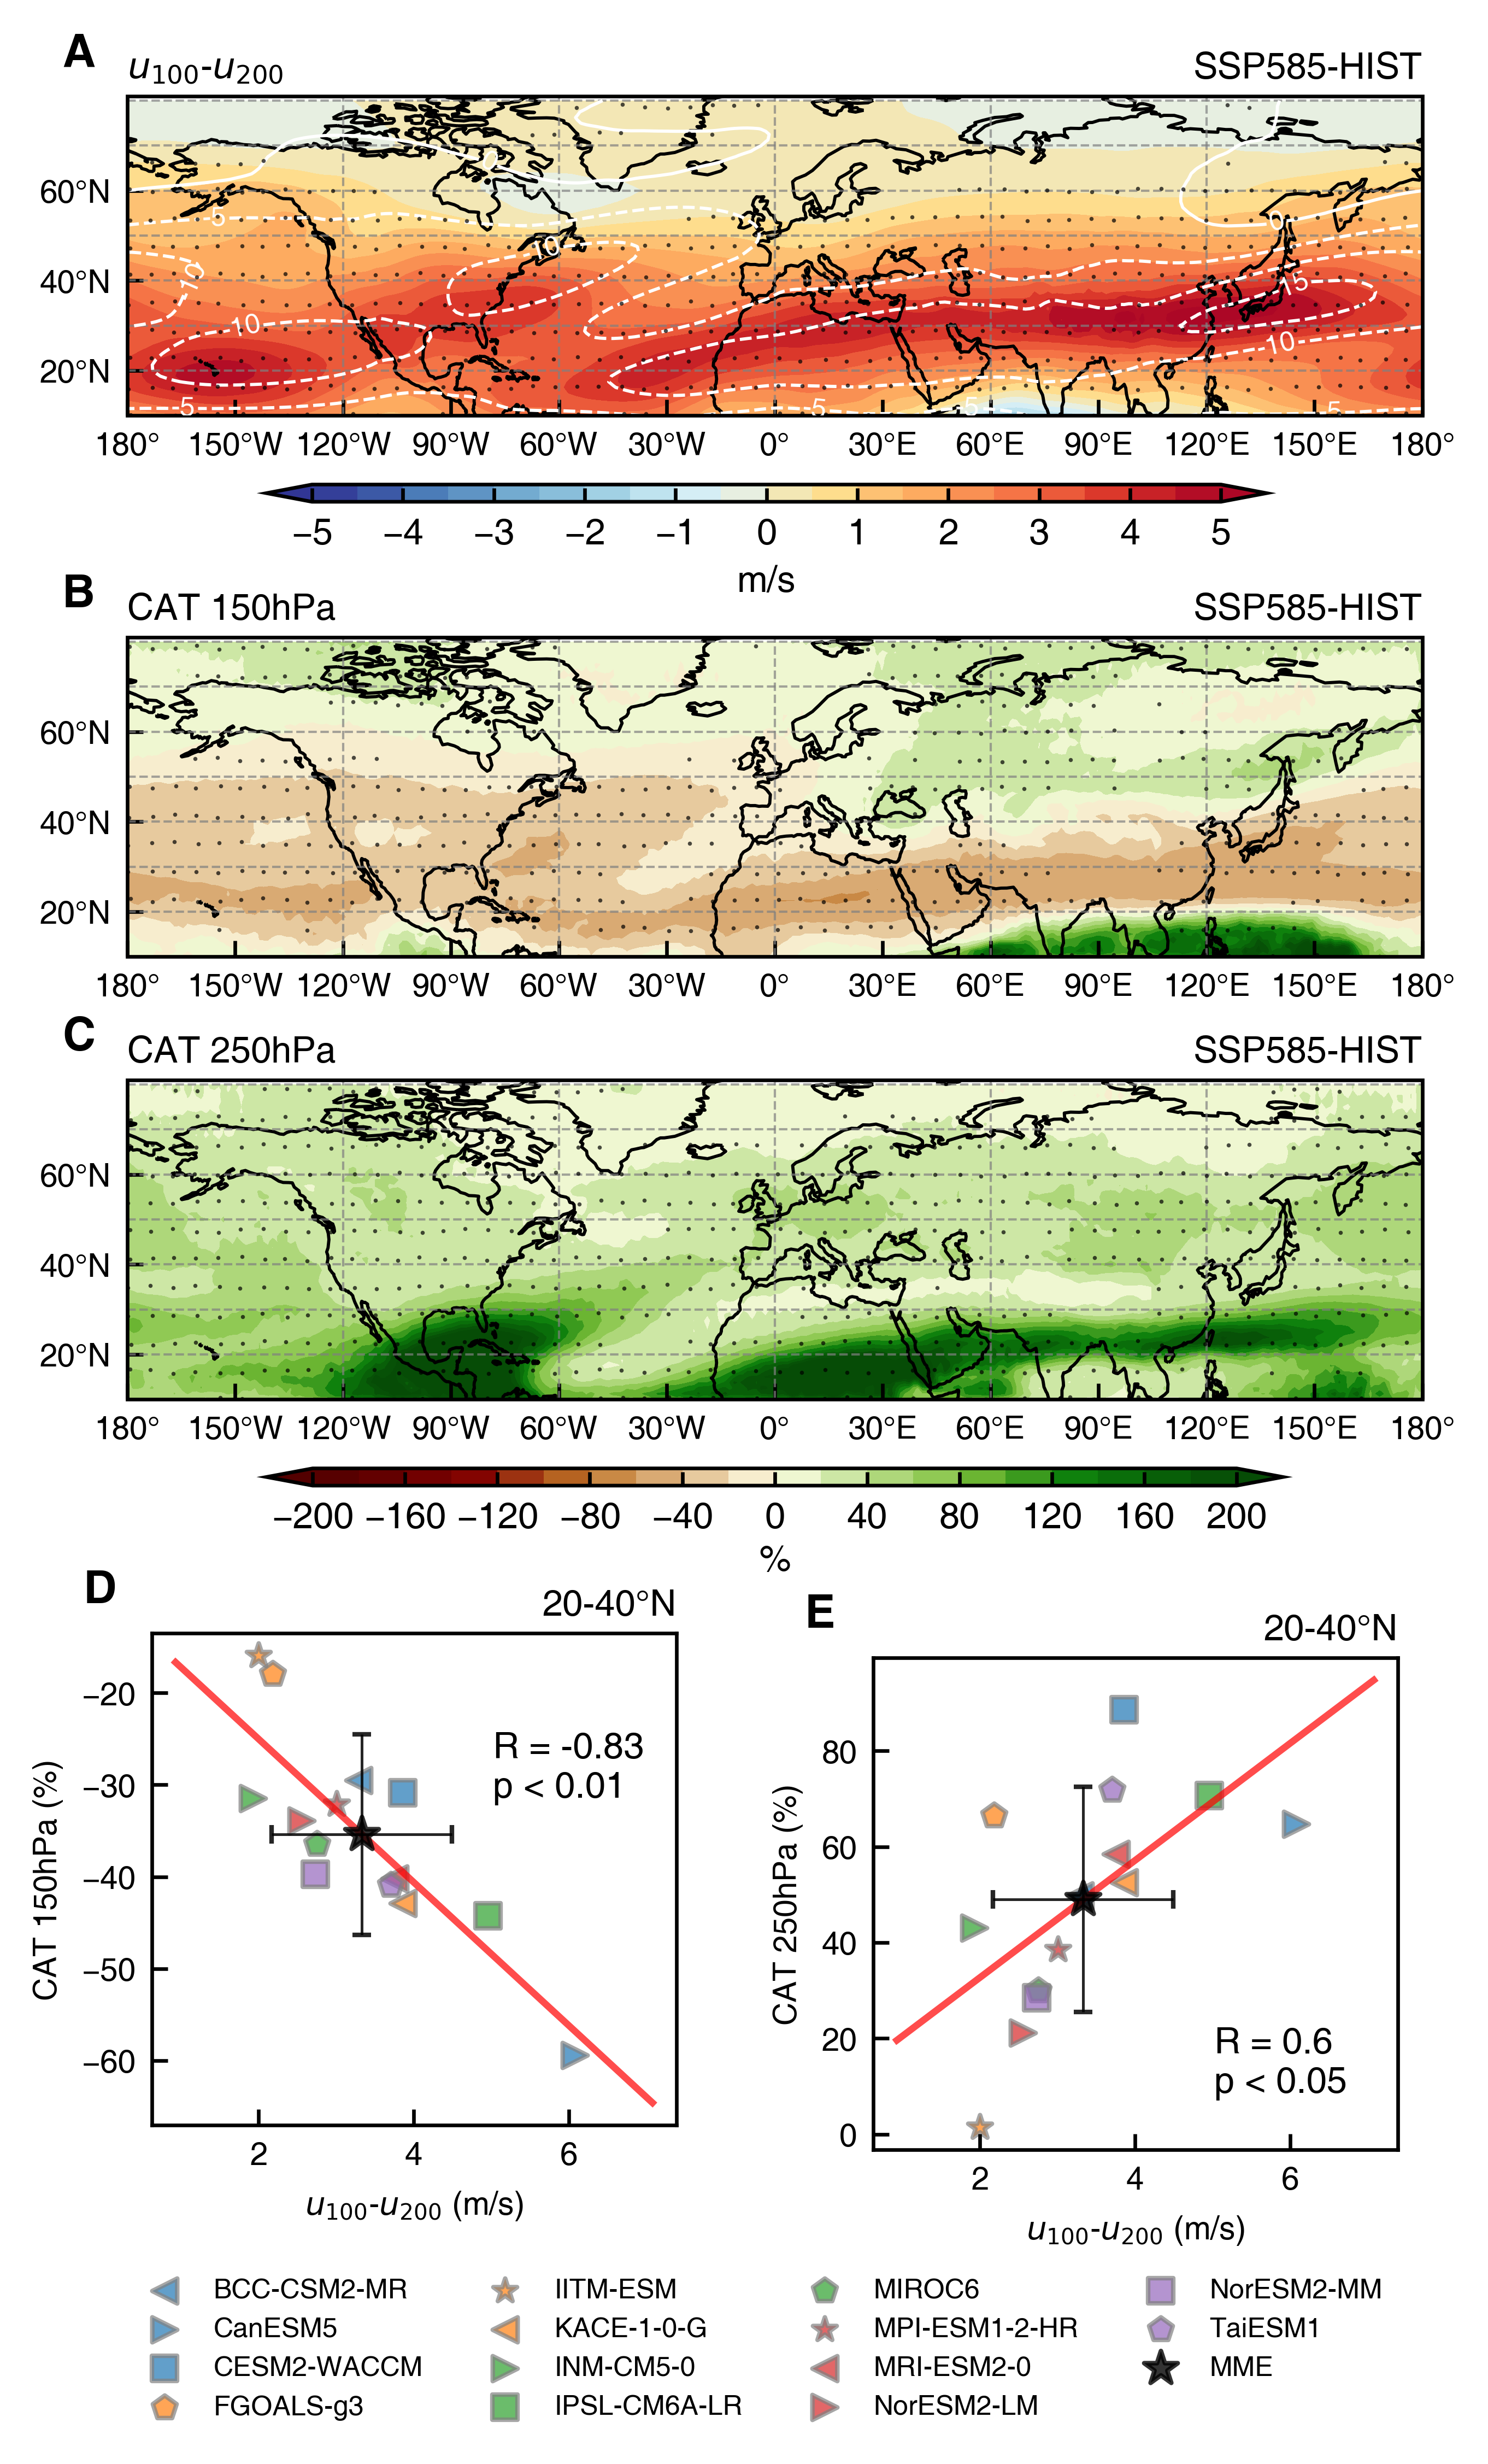

In [9]:
fig = plt.figure(figsize=(5, 7.5),dpi=600)
# 创建地图投影对象
axes = [[0.125,0.79,0.79,0.22],[0.125,0.57,0.79,0.22],[0.125,0.39,0.79,0.22],
        [0.14,0.14,0.32,0.2], [0.58,0.13,0.32,0.2]]
#创建lat 和 file
file = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_BCC-CSM2-MR_day_interpolated_289x145_N.nc'
lat = xr.open_dataset(file).lat.values
lat_indices = np.where((lat >= 10) & (lat <= 80))[0]
lat = xr.open_dataset(file).lat[lat_indices].values
lat2 = xr.open_dataset(file).lat
lon = xr.open_dataset(file).lon.values
########################################################################################
ax,contour = plot_trend(fig.add_axes(axes[0],projection=ccrs.PlateCarree()),lat, xr.open_dataset(file).lon.values,
                        ccmap_u,np.nanmean(u_change_upminuslow,axis=0),  np.linspace(-5, 5, 21) ,agreement_result,
           r"$u_{\text{100}}$-$u_{\text{200}}$","SSP585-HIST",
           'A',sequence_size=10,wind_speed_clim_mme=np.nanmean(u_1980_2010_upminuslow,axis=0),set_aspect_num=1.25)
cbar_ax = fig.add_axes([0.21, 0.8, 0.61, 0.007])
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='horizontal', pad=0.15, aspect=50, extend='both')
cbar.set_label(r'm/s',fontsize=8,labelpad=3)
cbar.set_ticks(np.linspace(-5, 5, 11))
cbar.ax.tick_params(axis='both', which='major', direction='in',length=3,labelsize=8)

ax,contour = plot_trend(fig.add_axes(axes[1],projection=ccrs.PlateCarree()),lat, xr.open_dataset(file).lon.values,
                       ccmap,(TI1_future_mme_150- TI1_hist_mme_150)/TI1_hist_mme_150*100,  np.linspace(-200, 200, 21) ,mme_consistency_TI1_150,
           "CAT 150hPa","SSP585-HIST",
           'B',sequence_size=10,set_aspect_num=1.25)
plot_trend(fig.add_axes(axes[2],projection=ccrs.PlateCarree()),lat, xr.open_dataset(file).lon.values,ccmap,
           (TI1_future_mme_250- TI1_hist_mme_250)/TI1_hist_mme_250*100,  np.linspace(-200, 200, 21) ,mme_consistency_TI1_250,
           "CAT 250hPa","SSP585-HIST",
           'C',sequence_size=10,set_aspect_num=1.25)#,bbox_list=[[180,210,20,40],[260,360,40,50],[20,80,25,35],[120,160,28,38]]
cbar_ax = fig.add_axes([0.21, 0.4, 0.62, 0.007])
# 添加横向 colorbar，并设置范围和箭头
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='horizontal', pad=0.15, aspect=50, extend='both')
cbar.set_label('%',fontsize=8,labelpad=2)
#cbar.set_label('%',fontsize=8)
cbar.set_ticks(np.linspace(-200, 200, 11))
cbar.ax.tick_params(axis='both', which='major', direction='in',length=3,labelsize=8)
markers = ['<', '>', 's', 'p', '*']
colors = ['#1F77B4',  # 深蓝
    '#FF7F0E',  # 橙色
    '#2CA02C',  # 绿色
    '#D62728',  # 红色
    '#9467BD',  # 紫色
    '#8C564B',  # 棕色
    '#E377C2',  # 粉色
    '#7F7F7F']   # 灰色

def plot_corr_scatter(ax,x_data,y_data,title,sequence,xlabel,ylabel):
    #if sequence != 'd':
    # 线性回归分析
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    extended_delta_u = np.linspace(min(x_data) - 1, max(x_data) + 1, 100)
    # 计算扩展范围内的回归值
    extended_line = slope * extended_delta_u + intercept
    ax.plot(extended_delta_u, extended_line, color='red', linewidth=1.5,alpha=0.7)

    # 绘制散点图
    for m in range(14):
        color_idx = m // 3  # Change color every 5 models
        marker_idx = m % len(markers)  # Cycle through markers
        ax.scatter(x_data[m], y_data[m], s=30, marker=markers[marker_idx],
                   color=colors[color_idx], label=models_list[m], alpha=0.7,edgecolors='grey')

    # ===== MME 平均点 + 1σ 误差棒 =====
    x_mean = np.nanmean(x_data)
    y_mean = np.nanmean(y_data)
    # ddof=1 → 样本标准差（更常用）；若你想用总体标准差可改为 ddof=0
    x_std = np.nanstd(x_data, ddof=1)
    y_std = np.nanstd(y_data, ddof=1)

    # 先画误差棒（在星标之下，zorder更低），再画星标
    # 两方向的 1σ：xerr 表示横向长度，yerr 表示纵向长度
    ax.errorbar(x_mean, y_mean,
                xerr=x_std, yerr=y_std,
                fmt='none', ecolor='k', elinewidth=.6, capsize=2,
                alpha=0.85, zorder=19)
    ax.scatter(x_mean, y_mean, marker='*', s=60, color='k',
               zorder=20, label='MME', alpha=0.8)
    # 添加图例、标签和标题
    ax.set_ylabel(ylabel,fontsize=7)
    ax.set_xlabel(xlabel,fontsize=7)
    if sequence == 'D':
        xy=(0.65,0.8)
    else:
        xy=(0.65,0.25)

    if f"{r_value:.2f}".endswith('0'):
        r_value_label = f"{r_value:.1f}"
    else:
        r_value_label = f"{r_value:.2f}"
    if p_value < 0.01:
        ax.annotate(f'R = {r_value_label}\np < 0.01', xy=xy, xycoords='axes fraction',
                   horizontalalignment='left', verticalalignment='top', fontsize=8)
    elif p_value < 0.05:
        ax.annotate(f'R = {r_value_label}\np < 0.05', xy=xy, xycoords='axes fraction',
                   horizontalalignment='left', verticalalignment='top', fontsize=8)
    else:
        ax.annotate(f'R = {r_value_label}\n$p4 = {p_value:.2f}', xy=xy, xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', fontsize=8)


    #ax.vlines(0, -2, 5, colors='grey', linestyles='--', linewidths=.5)
    #ax.hlines(0, -2, 12, colors='grey', linestyles='--',linewidths=.5)
    # 增大坐标轴标签和刻度的字体大小
    ax.tick_params(axis='both', which='major', direction='in',labelsize=7)#labelsize=7,
    # ax.set_title('Based on T', loc='left', fontsize=14)
    ax.set_title(title, loc='right',fontsize=8,pad=4)#, fontsize=7
    ax.text(-0.13, 1.13, sequence, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    return ax

plot_corr_scatter(fig.add_axes(axes[3]), u_upminuslow_N20_40,combined_freq_new_N20_40_150/combined_TI1_hist_new_N20_40_150*100,
                  '20-40°N','D',r'$u_{\text{100}}$-$u_{\text{200}}$ (m/s)','CAT 150hPa (%)')
ax=plot_corr_scatter(fig.add_axes(axes[4]), u_upminuslow_N20_40,combined_freq_new_N20_40_250/combined_TI1_hist_new_N20_40_250*100,
                  '20-40°N','E',r'$u_{\text{100}}$-$u_{\text{200}}$ (m/s)','CAT 250hPa (%)')
print(combined_freq_new_N20_40_250)
print(np.nanmean(combined_freq_new_N20_40_150/combined_TI1_hist_new_N20_40_150*100))
print(np.nanmean(combined_freq_new_N20_40_250/combined_TI1_hist_new_N20_40_250*100))
plt.legend(fontsize=6, frameon=False,ncol=4,bbox_to_anchor=(-1.45, -0.6),loc='lower left')
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.4.TI150_250_95p_RELAchange_pattern_and_u100minus200_scatter.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.4.TI150_250_95p_RELAchange_pattern_and_u100minus200_scatter.svg',format='svg',dpi=300)
plt.show()